### Imports

In [1]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

### Ground truth map mesh

In [5]:
verts, faces, aux = load_obj(os.path.join('../../data/meshes/simple_cave_01.obj'))

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We construct a Meshes structure for the target mesh
meshes = Meshes(verts=[verts], faces=[faces_idx])

### Point cloud to compare

In [3]:
def plot_pointcloud(inputs, title=""):
    assert isinstance(inputs, Meshes) or isinstance(inputs, Pointclouds) or isinstance(inputs, torch.Tensor)
    if isinstance(inputs, Meshes):
        # Sample points uniformly from the surface of the mesh.
        points = sample_points_from_meshes(inputs, 5000)
    elif isinstance(inputs, Pointclouds):
        points = inputs.points_list()[0]
    elif isinstance(inputs, torch.Tensor):
        points = inputs
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [4]:
# points = sample_points_from_meshes(map_gt_mesh, 5000)
points = verts[None][:, torch.randint(verts.shape[0], (5000,)), :]
pcls = Pointclouds(points)

<IPython.core.display.Javascript object>


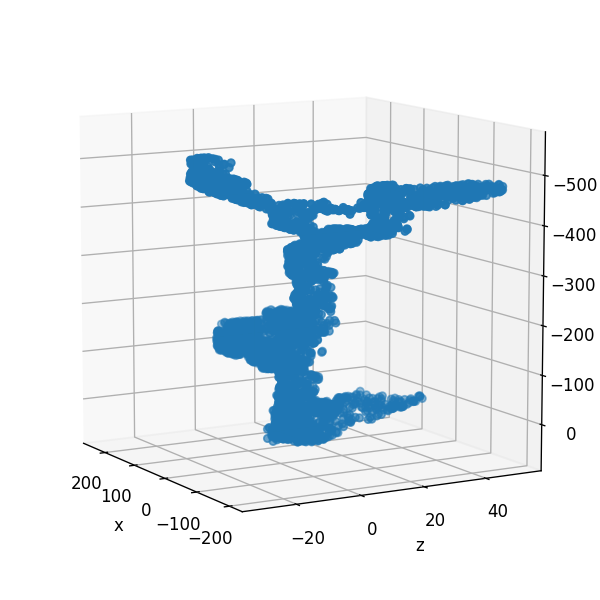

In [6]:
plot_pointcloud(meshes)

<IPython.core.display.Javascript object>


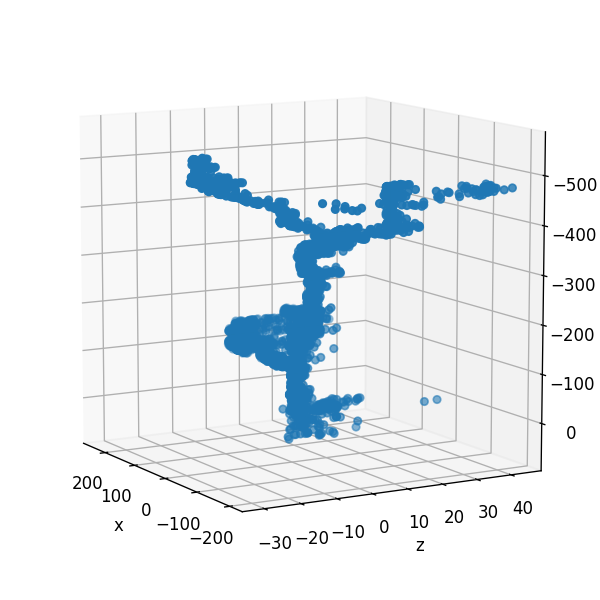

In [7]:
plot_pointcloud(pcls)

### Compare mesh to point cloud

In [8]:
# Compare mesh and point cloud:
# https://pytorch3d.readthedocs.io/en/latest/modules/loss.html#pytorch3d.loss.point_mesh_edge_distance
from pytorch3d.loss import point_mesh_edge_distance, point_mesh_face_distance
from rpz_planning import point_face_distance_truncated
from rpz_planning import point_edge_distance_truncated
from rpz_planning import face_point_distance_truncated
from rpz_planning import edge_point_distance_truncated
from rpz_planning import chamfer_distance_truncated

In [9]:
for s in range(50, 5051, 1000):
    points = verts[None][:, torch.randint(verts.shape[0], (s,)), :]
    pcls = Pointclouds(points)
    print('Num sampled points:', s)
    print('EP:', edge_point_distance_truncated(meshes=meshes, pcls=pcls))
    print('PE:', point_edge_distance_truncated(meshes=meshes, pcls=pcls))
    print('EPPE:', point_mesh_edge_distance(meshes=meshes, pcls=pcls).sqrt())
    print('\n')
    
    print('FP:', face_point_distance_truncated(meshes=meshes, pcls=pcls))
    print('PF:', point_face_distance_truncated(meshes=meshes, pcls=pcls))
    print('FPPF:', point_mesh_face_distance(meshes=meshes, pcls=pcls).sqrt())
    print('-'*30)

Num sampled points: 50
EP: tensor(15.8047, device='cuda:0')
PE: tensor(0., device='cuda:0')
EPPE: tensor(20.8887, device='cuda:0')


FP: tensor(15.7131, device='cuda:0')
PF: tensor(0., device='cuda:0')
FPPF: tensor(20.8041, device='cuda:0')
------------------------------
Num sampled points: 1050
EP: tensor(2.2244, device='cuda:0')
PE: tensor(0., device='cuda:0')
EPPE: tensor(3.0883, device='cuda:0')


FP: tensor(2.1568, device='cuda:0')
PF: tensor(2.4334e-11, device='cuda:0')
FPPF: tensor(3.0112, device='cuda:0')
------------------------------
Num sampled points: 2050
EP: tensor(1.5720, device='cuda:0')
PE: tensor(0., device='cuda:0')
EPPE: tensor(2.2793, device='cuda:0')


FP: tensor(1.5080, device='cuda:0')
PF: tensor(2.1094e-11, device='cuda:0')
FPPF: tensor(2.2023, device='cuda:0')
------------------------------
Num sampled points: 3050
EP: tensor(1.2378, device='cuda:0')
PE: tensor(1.5268e-12, device='cuda:0')
EPPE: tensor(1.7727, device='cuda:0')


FP: tensor(1.1761, device='cuda

In [11]:
import trimesh

In [12]:
mesh = trimesh.load('../../data/meshes/simple_cave_01.obj')

In [33]:
# find the closest point on the mesh to each random point
(closest_points,
distances,
triangle_id) = mesh.nearest.on_surface(mesh.vertices[np.random.choice(len(mesh.vertices), 10)])
print('Distance from point to surface of mesh:\n{}'.format(distances))

Distance from point to surface of mesh:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [44]:
from pytorch3d import loss
import torch
from pytorch3d.structures.meshes import Meshes as torch_mesh
from pytorch3d.structures.pointclouds import Pointclouds as torch_pc

vertecies = [torch.Tensor([[10.67399979, 8.61225986, 0.77146602],
                           [10.67269993, 8.61141968, 0.77197701],
                           [10.67399979, 8.61225986, 0.77197701]])]
faces = [torch.Tensor([[0, 1, 2]])]
points_tensor = [torch.Tensor([[5, 5, 5]])]
torch_mesh_test = torch_mesh(verts=vertecies, faces=faces, textures=None)
torch_pc_test = torch_pc(points_tensor)
torch_error = loss.point_mesh_face_distance(torch_mesh_test, torch_pc_test)
print(torch_error)

tensor(0.0042)


In [12]:
for num_points in tqdm(range(1000, 10_000, 1000)):
    points = sample_points_from_meshes(map_gt_mesh, num_points)
    point_cloud = Pointclouds(points)

    loss_edge = point_mesh_edge_distance(meshes=map_gt_mesh, pcls=point_cloud)
    loss_face = point_mesh_face_distance(meshes=map_gt_mesh, pcls=point_cloud)
    print(f'Num sampled points: {num_points}, \
          loss_edge :{loss_edge.detach().cpu().numpy():.6f} \
          loss_face :{loss_face.detach().cpu().numpy():.6f}')

  0%|          | 0/9 [00:00<?, ?it/s]

Num sampled points: 1000,           loss_edge :16.268873           loss_face :15.782888
Num sampled points: 2000,           loss_edge :8.011655           loss_face :7.637700
Num sampled points: 3000,           loss_edge :5.356560           loss_face :5.011217
Num sampled points: 4000,           loss_edge :3.712798           loss_face :3.408644
Num sampled points: 5000,           loss_edge :3.202473           loss_face :2.917641
Num sampled points: 6000,           loss_edge :2.523832           loss_face :2.271514
Num sampled points: 7000,           loss_edge :2.330510           loss_face :2.066784
Num sampled points: 8000,           loss_edge :1.991784           loss_face :1.755617
Num sampled points: 9000,           loss_edge :1.788551           loss_face :1.565995


In [90]:
from pytorch3d.ops.knn import knn_points

length = 1000
x = 1000*torch.rand([1, length, 3]) - 500
y = 1000*torch.rand([1, length, 3]) - 500

In [93]:
x_nn = knn_points(x, y, lengths1=torch.tensor(length)[None], lengths2=torch.tensor(length)[None], K=1)

<ipython-input-93-97b2dabe3409>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_nn = knn_points(x, y, lengths1=torch.tensor(length)[None], lengths2=torch.tensor(length)[None], K=1)


In [115]:
y[:, x_nn.idx[x_nn.dists.sqrt() < 50], :]

tensor([[[ 211.9046,  498.3814,  294.3831],
         [ 108.8777,   50.6627, -442.3596],
         [-104.6068,   98.4180, -168.2677],
         ...,
         [  37.2074, -306.2638, -114.0586],
         [-381.2786,  389.1953,  250.7827],
         [ 393.5919,  -96.0489, -442.6964]]])